<a href="https://colab.research.google.com/github/xxshenanigans/Project4/blob/main/AI_04_%EC%A0%95%EC%A7%80%ED%98%9C_Section4(pt).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA SCIENCE / SECTION 4 / PROJECT**

---

> Text Image를 입력해서 그와 유사한 Image를 출력할 수 있을까 🤔

## 🤖 목차 

1. 개요
2. 모델 설계 및 학습 
3. 문자 벡터화 및 유사도 측정 
4. 결과 출력
5. 마무리 

---

#개요
- 관심 데이터 선정
- 데이터 선정 이유
- 데이터를 이용한 가설

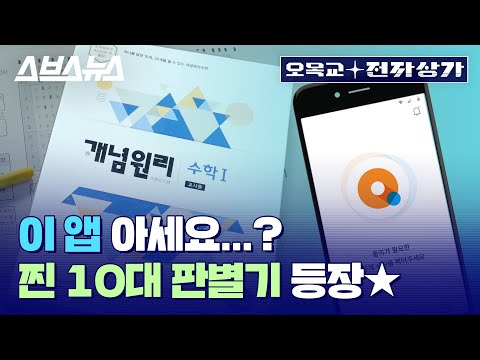

In [ ]:
from IPython.display import YouTubeVideo 
YouTubeVideo('3UREk0eMJH0', width=600, height=400)

#모델 설계 및 학습 

문자인식(Character Recognition)이란 시각 정보를 통하여 문자를 인식하고 의미를 이해하는 인간의 능력을 컴퓨터로 실현하려는 패턴인식(Pattern Recognition)의 한 분야로서, 광학 문자 인식(Optical Character Recognition), 우편물 자동 분류, 문서인식, 도면인식 등의 분야에서 부분적으로 실용화가 이루어지게 되었으며, 요즈음에는 인공지능(Artificial Intelligence)의 최신기법인 신경망(Neural Network)과 접목에 의해 문자인식 기술은 새로운 단계에 접어들게 되었습니다.

 - OpenCV&딥러닝
 - pytesseract
 - CRNN

###라이브러리 설치###

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,830 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import sys, cv2 
import random
import h5py
import os
import pytesseract
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

from numpy import dot 
from numpy.linalg import norm
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Reshape, Bidirectional, LSTM, Dense, Lambda, BatchNormalization, MaxPooling2D, Activation, Dropout, Flatten
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from PIL import Image
from google.colab.patches import cv2_imshow

##**OpenCV+딥러닝을 적용한 연속 문자 인식**##

OpenCV와 딥러닝을 사용해 다음과 같은 이미지에 있는 숫자를 인식해 보겠습니다.

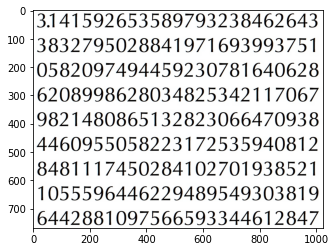

###OpenCV를 이용하여 글자가 적힌 영역 추출하기###

여러 개의 글자가 적혀 있으므로 이미지에서 문자가 어디에 적혀 있는지 검출해야 합니다. 

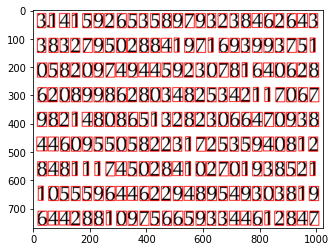

In [ ]:
im = cv2.imread('/content/numbers100.jpg')

gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  if h < 20: continue # 너무 작으면 건너뛰기
  red = (0, 0, 255) 
  cv2.rectangle(im, (x, y), (x+w, y+h), red, 2)

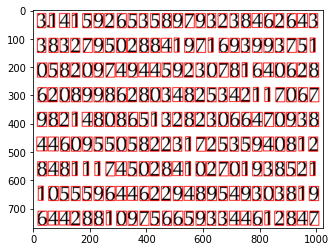

In [ ]:
cv2.imwrite('numbers100-contour.png', im) 

image = mpimg.imread("numbers100-contour.png")
plt.imshow(image); plt.show()

###딥러닝을 이용하여 문자 인식 데이터 만들기###

각 문자 영역을 추출했으므로 각 글자를 인식시켜 보겠습니다. MNIST의 손글씨 숫자 데이터를 Keras + TensorFlow를 이용하여 학습한 다음 문자를 인식시켜 보겠습니다. 

####데이터셋 불러오기

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

X_train /= 255; X_test /= 255

In [ ]:
y_train = np_utils.to_categorical(y_train, 10)
y_test  = np_utils.to_categorical(y_test , 10)

####모델 설계

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

####모델 학습

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=600, epochs=10)

Epoch 1/10
100/100 [==============================] - 4s 10ms/step - loss: 0.4129 - accuracy: 0.8813 - val_loss: 0.1630 - val_accuracy: 0.9510
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1462 - accuracy: 0.9569 - val_loss: 0.0982 - val_accuracy: 0.9693
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0958 - accuracy: 0.9709 - val_loss: 0.0787 - val_accuracy: 0.9758
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0741 - accuracy: 0.9779 - val_loss: 0.0689 - val_accuracy: 0.9785
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.0664 - val_accuracy: 0.9782
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0447 - accuracy: 0.9857 - val_loss: 0.0589 - val_accuracy: 0.9808
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.0610 - val_accuracy: 0.9819
Epoch

In [ ]:
rects = []
im_w = im.shape[1]

for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)

    if w < 10 or h < 10: continue
    
    if w > im_w / 5: continue  

    y2 = round(y/10)*10 
    index = y2 * im_w + x

    rects.append((index, x, y, w, h))

In [ ]:
rects = sorted(rects, key=lambda x:x[0]) 

X = []
for i, r in enumerate(rects):
    index, x, y, w, h = r

    num = gray[y:y+h, x:x+w] 
    num = 255 - num 

    ww = round((w if w > h else h) * 1.85)
    spc = np.zeros((ww, ww))

    wy = (ww-h)//2
    wx = (ww-w)//2

    spc[wy:wy+h, wx:wx+w] = num

    num = cv2.resize(spc, (28, 28))
    
    num = num.reshape(28*28)
    num = num.astype("float32") / 255
    X.append(num)

####결과 예측

In [ ]:
s="314159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230" +\
"664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847"

answer = list(s)

correct = 0

nlist = model.predict(np.array(X))

for i, n in enumerate(nlist):
    ans = n.argmax()

    if ans == int(answer[i]):
        correct += 1

    else:
        print("[ng]", i, "번째", ans, " != ", answer[i])

print("정답률 : ", correct / len(nlist))

[ng] 5 번째 4  !=  9
[ng] 11 번째 4  !=  8
[ng] 12 번째 4  !=  9
[ng] 14 번째 4  !=  9
[ng] 18 번째 4  !=  8
[ng] 26 번째 4  !=  8
[ng] 30 번째 4  !=  9
[ng] 34 번째 4  !=  8
[ng] 35 번째 4  !=  8
[ng] 38 번째 4  !=  9
[ng] 42 번째 4  !=  9
[ng] 44 번째 4  !=  9
[ng] 45 번째 4  !=  9
[ng] 50 번째 1  !=  0
[ng] 51 번째 0  !=  5
[ng] 52 번째 5  !=  8
[ng] 53 번째 4  !=  2
[ng] 54 번째 2  !=  0
[ng] 55 번째 0  !=  9
[ng] 56 번째 4  !=  7
[ng] 57 번째 7  !=  4
[ng] 58 번째 4  !=  9
[ng] 61 번째 4  !=  5
[ng] 62 번째 5  !=  9
[ng] 63 번째 4  !=  2
[ng] 64 번째 2  !=  3
[ng] 65 번째 3  !=  0
[ng] 66 번째 0  !=  7
[ng] 67 번째 7  !=  8
[ng] 68 번째 4  !=  1
[ng] 74 번째 4  !=  8
[ng] 78 번째 4  !=  8
[ng] 79 번째 4  !=  9
[ng] 80 번째 4  !=  9
[ng] 81 번째 4  !=  8
[ng] 84 번째 4  !=  8
[ng] 88 번째 4  !=  8
[ng] 100 번째 4  !=  9
[ng] 101 번째 4  !=  8
[ng] 105 번째 4  !=  8
[ng] 107 번째 4  !=  8
[ng] 113 번째 4  !=  8
[ng] 122 번째 4  !=  9
[ng] 124 번째 4  !=  8
[ng] 129 번째 4  !=  9
[ng] 134 번째 4  !=  8
[ng] 144 번째 4  !=  9
[ng] 147 번째 4  !=  8
[ng] 150 번째 4  !=  8
[ng] 152 

##**파이썬 OCR 라이브러리 - pytesseract로 OCR 해보기(이미지 문자 읽기)**

OCR(Optical Character Recognition)은 사람이 쓰거나 기계로 인쇄한 문자의 영상을 이미지 스캐너로 획득하여 기계가 읽을 수 있는 문자로 변환하는 것을 뜻합니다. 

650 3428



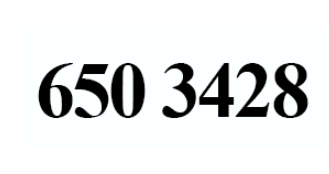

In [ ]:
image = cv2.imread('/content/R1280x0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename), lang = None)
os.remove(filename)

print(text)
cv2_imshow(image)

PREREQUISITES

In order to make the most of this, you will need to have
a little bit of programming experience. All examples in this
book are in the Python programming language. Familiarity
with Python or other scripting languages is suggested, but
not required.

You'll also need to know some basic mathematics. This
book is hands-on and example driven: lots of examples and
lots of code, so even if your math skills are not up to par,
do not worry! The examples are very detailed and heavily
documented to help you follow along.



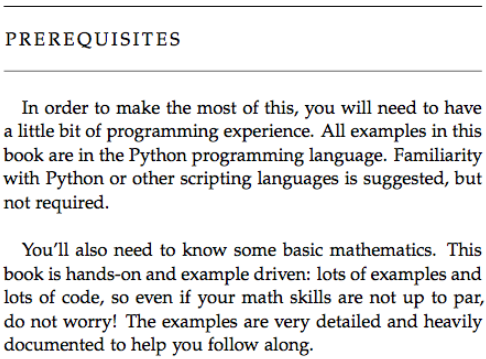

In [ ]:
image = cv2.imread('/content/R1280x1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename), lang = None)
os.remove(filename)

print(text)
cv2_imshow(image)

Sees oes

‘Mr Johnny Welsh 30 October 2003
46 Baker Street

London

NW2 2LK,

GREAT BRITAIN

 



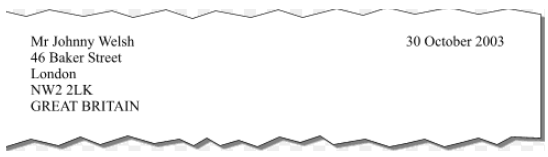

In [ ]:
image = cv2.imread('/content/R1280x2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename), lang = None)
os.remove(filename)

print(text)
cv2_imshow(image)

3.141592653589793238462643
3832795028841971693993751
0582097494459230781640628
6208998628034825342117067
9821480865 132823066470938
446095505822317253594081 2
8481117450284102701938521
1055596446229489549303819
6442881097566593344612847



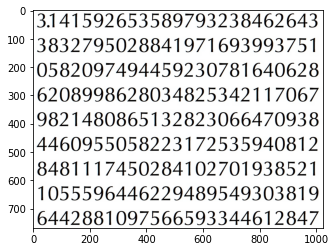

In [ ]:
image = cv2.imread('/content/numbers100.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename), lang = None)
os.remove(filename)

print(text)
plt.imshow(image); plt.show()

CHEBP! N



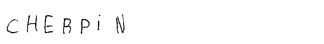

In [ ]:
image = cv2.imread('/content/drive/MyDrive/input/test/TEST_0005.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename), lang = None)
os.remove(filename)

print(text)
cv2_imshow(image)

##**CRNN을 활용한 손글씨 문자 인식**

손글씨 문자를 인식하기 위해 CRNN(CNN+RNN) 모델을 훈련합니다. 

CRNN 모델 구축에는 Keras를 사용합니다.

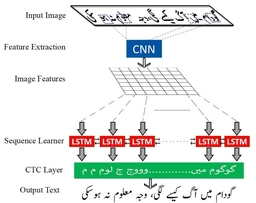

###데이터셋 불러오기###

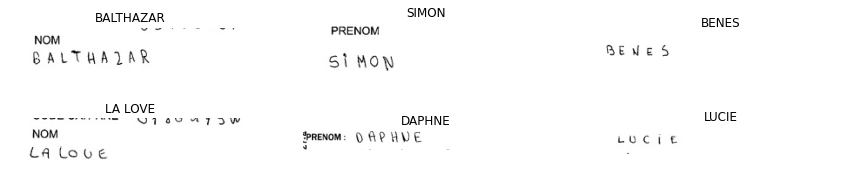

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/input/written_name_train_v2.csv')
valid = pd.read_csv('/content/drive/MyDrive/input/written_name_validation_v2.csv')

In [ ]:
train = train.head(33001)
valid = valid.head(4201)

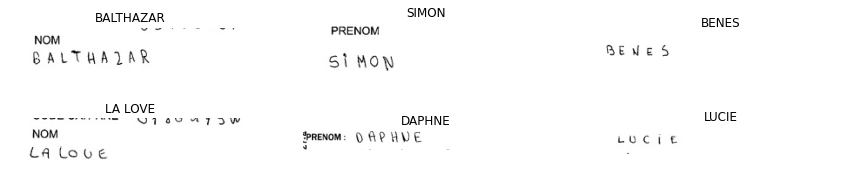

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

###데이터 전처리###
 - 결측치 제거 
 - 'UNREADABLE' 제거
 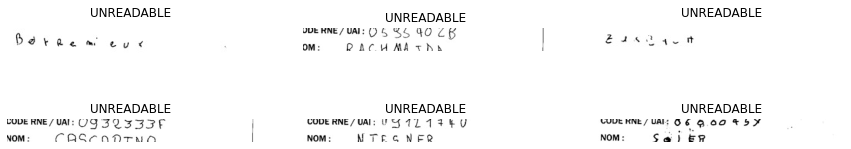
 - 라벨링 대문자로 통일

In [ ]:
print(train['IDENTITY'].isnull().sum())
print(valid['IDENTITY'].isnull().sum())

56
10


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

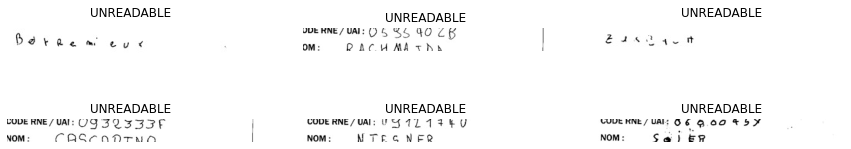

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [ ]:
print(train.shape)
train.head(2)

(32934, 2)


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON


In [ ]:
print(valid.shape)
valid.head(2)

(4189, 2)


,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER


###이미지 전처리###
- grayscale 적용
- 만약 크기가 기준보다 크면 크롭하고, 작으면 화이트 픽셀로 패딩하여 모두 같은 크기로 조정 
- 0~1 범위로 정규화 

In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255   # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 16000
valid_size= 4000

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/content/drive/MyDrive/input/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/drive/MyDrive/input/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

###단어를 숫자로 변환###

JIHYE ➡︎ [ 9  8  7 24  4]

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24   # max length of input labels
num_of_characters = len(alphabets) + 1   # +1 for ctc pseudo blank
num_of_timestamps = 64   # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:   # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JIHYE'
print(name, '\n',label_to_num(name))

JIHYE 
 [ 9  8  7 24  4]


In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

###모델 설계

In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

# OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

###모델 학습
- Correct characters predicted : 75.90%
- Correct words predicted      : 56.85%

In [ ]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
94/94 [==============================] - 50s 455ms/step - loss: 21.0239 - val_loss: 23.6673
Epoch 2/60
94/94 [==============================] - 39s 411ms/step - loss: 20.0746 - val_loss: 22.1221
Epoch 3/60
94/94 [==============================] - 38s 408ms/step - loss: 19.7699 - val_loss: 20.2342
Epoch 4/60
94/94 [==============================] - 38s 408ms/step - loss: 19.4048 - val_loss: 19.6408
Epoch 5/60
94/94 [==============================] - 38s 409ms/step - loss: 18.9230 - val_loss: 18.8202
Epoch 6/60
94/94 [==============================] - 38s 407ms/step - loss: 18.3387 - val_loss: 18.1713
Epoch 7/60
94/94 [==============================] - 38s 408ms/step - loss: 17.5795 - val_loss: 17.4255
Epoch 8/60
94/94 [==============================] - 39s 412ms/step - loss: 16.8595 - val_loss: 16.7896
Epoch 9/60
94/94 [==============================] - 38s 407ms/step - loss: 16.0821 - val_loss: 16.8846
Epoch 10/60
94/94 [==============================] - 38s 406ms/step - los

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 75.90%
Correct words predicted      : 56.85%


###결과 예측 

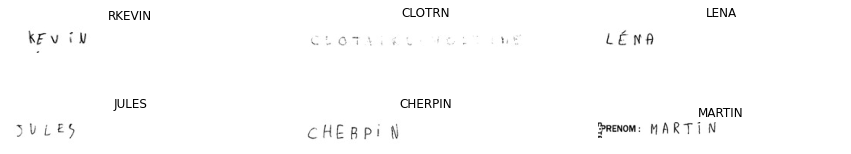

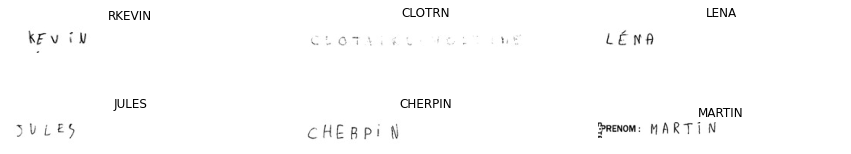

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/input/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

#유사 이미지 출력

##단어 벡터화

In [ ]:
train_copy = train.copy()

In [ ]:
def bin(name):

    chars = []

    for i in alphabets:
        count = 0
        for j in name:
            if i == j:
                count +=1
        chars.append(count)

    return chars

train_copy['bin'] = train_copy['IDENTITY'].apply(lambda x: bin(x)) 

In [ ]:
train_copy

,FILENAME,IDENTITY,bin
0,TRAIN_00001.jpg,BALTHAZAR,"[3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,TRAIN_00002.jpg,SIMON,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
2,TRAIN_00003.jpg,BENES,"[0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,TRAIN_00004.jpg,LA LOVE,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, ..."
4,TRAIN_00005.jpg,DAPHNE,"[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
32929,TRAIN_32997.jpg,LEANE,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
32930,TRAIN_32998.jpg,DEBONNE,"[0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, ..."
32931,TRAIN_32999.jpg,PAUL,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
32932,TRAIN_33000.jpg,LOPA,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."


##코사인유사도 측정

In [ ]:
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def get_recommendations(text):

    text = bin(text)

    cosine_sim = []
    for i in range(len(train_copy)):
        cosine_sim.append(cos_sim(text, train_copy['bin'][i]))

    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:6]

    text_indices = [j[0] for j in sim_scores]

    plt.figure(figsize=(15, 10))

    for k in range(6):
        ax = plt.subplot(2, 3, k+1)
        
        img_dir = '/content/drive/MyDrive/input/train/'+train.loc[text_indices[k], 'FILENAME']
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        
        plt.imshow(image, cmap='gray')
        plt.title(train.loc[text_indices[k], 'IDENTITY'], fontsize=12)
        plt.axis('off')

    return plt.subplots_adjust(wspace=0.2, hspace=-0.8)

##결과 출력 

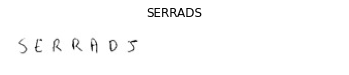

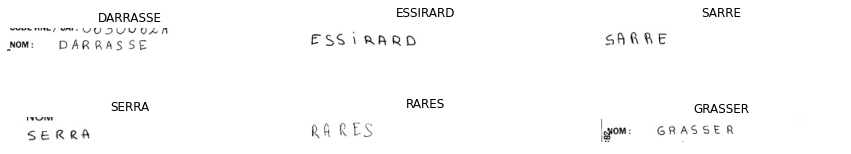

SERRADS


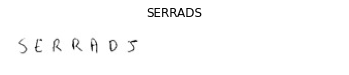

In [ ]:
idx = 125
img_dir = '/content/drive/MyDrive/input/test/'+test.loc[idx, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
text = num_to_label(decoded[0])
plt.title(text, fontsize=12)
plt.axis('off')

print(test.loc[idx, 'IDENTITY'])   
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

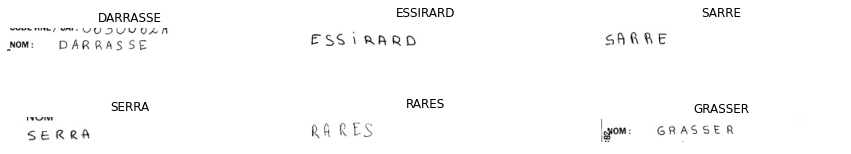

In [ ]:
get_recommendations(text)